In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast

import warnings
warnings.filterwarnings("ignore")

## prepare data

In [19]:
df=pd.read_csv('movies_metadata.csv',encoding='windows-1252')

In [20]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [21]:
df_fran=df[df.belongs_to_collection.notnull()]
related_columns=['belongs_to_collection','budget','genres','popularity','production_companies','release_date',
                 'revenue','runtime','tagline','title','vote_average','vote_count']
df_fran=df_fran[related_columns]
#df_fran.head(3)

## feature engineer
### collection, product year, film's vote percent among all films in same year, adjusted revenue after considering inflation

create collection

In [22]:
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

create year

In [23]:
def get_year(x):
    try:
        return str(x).split('/')[2]
    except:
        return np.nan
df_fran['year']=df_fran['release_date'].apply(get_year)

inflation adjusted coefficient. Data from https://www.the-numbers.com/market/![image.png](attachment:image.png)

In [24]:
adj=pd.read_csv('inflation.csv')
infla=adj[['year','Inflation rate']]

infla.year=infla.year.apply(str)
df_fran=df_fran.merge(infla)
df_fran['adj_revenue']=df_fran['revenue']*df_fran['Inflation rate']


## Explore the missing value in revenue

In [25]:
df_fran[df_fran['revenue']>0].shape

(989, 15)

In [26]:
df_fran[df_fran['revenue']==0].shape

(1632, 15)

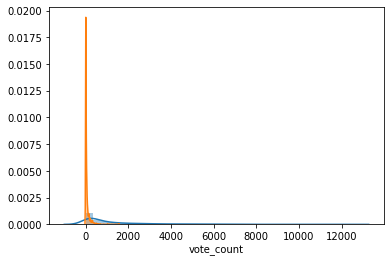

In [27]:
sns.distplot(df_fran[df_fran['revenue']>0]['vote_count'])
sns.distplot(df_fran[df_fran['revenue']==0]['vote_count'])

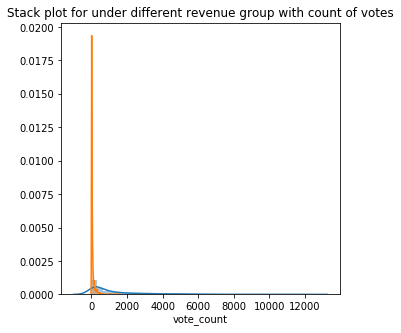

In [28]:
fig, axs = plt.subplots(figsize=(5,5))
sns.distplot(df_fran[df_fran['revenue']>0]['vote_count']).title.set_text('Stack plot for under different revenue group with count of votes')
sns.distplot(df_fran[df_fran['revenue']==0]['vote_count'])
#sns.distplot(df_fran[df_fran['revenue']>0]['vote_count'],ax=axs[2])
#sns.distplot(df_fran[df_fran['revenue']==0]['vote_count'],ax=axs[1])


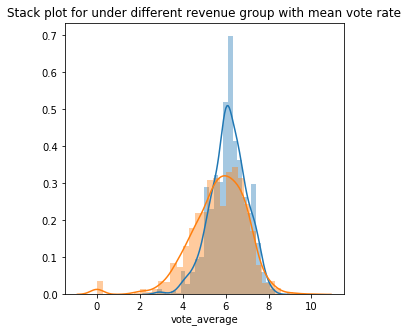

In [29]:
#fig, axs = plt.subplots(ncols=3,figsize=(15,5))
#sns.distplot(df_fran[df_fran['revenue']>0]['vote_average'],ax=axs[0])
#sns.distplot(df_fran[df_fran['revenue']==0]['vote_average'],ax=axs[0])
#sns.distplot(df_fran[df_fran['revenue']>0]['vote_average'],ax=axs[1])
#sns.distplot(df_fran[df_fran['revenue']==0]['vote_average'],ax=axs[2])
fig, axs = plt.subplots(figsize=(5,5))
sns.distplot(df_fran[df_fran['revenue']>0]['vote_average']).title.set_text('Stack plot for under different revenue group with mean vote rate')
sns.distplot(df_fran[df_fran['revenue']==0]['vote_average'])


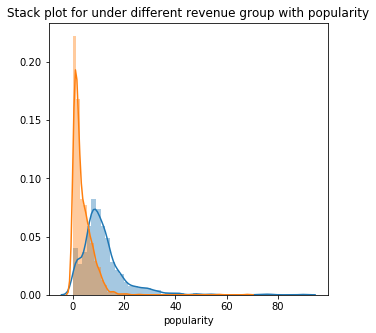

In [30]:
#df_fran=df_fran.drop([35587]) # for this row popularity = 'Beware Of Frost Bites'
df_fran['popularity']=df_fran['popularity'].apply(float)

#fig, axs = plt.subplots(ncols=3,figsize=(15,5))
#sns.distplot(df_fran[(df_fran['popularity']<100)&(df_fran['revenue']>0)]['popularity'],ax=axs[0])
#sns.distplot(df_fran[(df_fran['popularity']<100)&(df_fran['revenue']==0)]['popularity'],ax=axs[0])
#sns.distplot(df_fran[(df_fran['popularity']<100)&(df_fran['revenue']>0)]['popularity'],ax=axs[1])
#sns.distplot(df_fran[(df_fran['popularity']<100)&(df_fran['revenue']==0)]['popularity'],ax=axs[2])

fig, axs = plt.subplots(figsize=(5,5))
sns.distplot(df_fran[(df_fran['popularity']<100)&(df_fran['revenue']>0)]['popularity']).title.set_text('Stack plot for under different revenue group with popularity')
sns.distplot(df_fran[(df_fran['popularity']<100)&(df_fran['revenue']==0)]['popularity'])

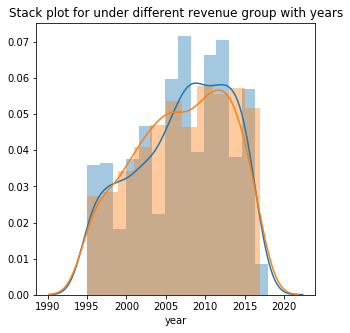

In [31]:
#fig, axs = plt.subplots(ncols=3,figsize=(15,5))

#sns.distplot(df_fran[df_fran['revenue']==0]['year'],ax=axs[0]).title.set_text('distribution of movies without revenue per year')
#sns.distplot(df_fran[df_fran['revenue']>0]['year'],ax=axs[0])
#sns.distplot(df_fran[df_fran['revenue']==0]['year'],ax=axs[1]).title.set_text('distribution of movies without revenue per year')
#sns.distplot(df_fran[df_fran['revenue']>0]['year'],ax=axs[2]).title.set_text('distribution of movies having revenue per year')

fig, axs = plt.subplots(figsize=(5,5))

sns.distplot(df_fran[df_fran['revenue']==0]['year']).title.set_text('Stack plot for under different revenue group with years')
sns.distplot(df_fran[df_fran['revenue']>0]['year'])

## Defined the collection having most business value from aspects


### Check the vote percentage

In [32]:
fran_pivot_vote = df_fran.pivot_table(index='year', values='vote_count', aggfunc={'vote_count': ['mean', 'sum', 'count','std']}).reset_index()


df_fran=df_fran.merge(fran_pivot_vote[['year','sum']])
df_fran=df_fran.rename(columns={'sum':'year_total_vote','belongs_to_collection':'collection'})
df_fran['vote_percent']=df_fran['vote_count']/df_fran['year_total_vote']

,collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,tagline,title,vote_average,vote_count,year,Inflation rate,adj_revenue,year_total_vote,vote_percent
0,Toy Story Collection,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,NaN,Toy Story,7.7,5415.0,1995,2.09425,7.823155e+08,25170.0,0.215137
1,Grumpy Old Men Collection,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995,2.09425,0.000000e+00,25170.0,0.003655
2,Father of the Bride Collection,0,"[{'id': 35, 'name': 'Comedy'}]",8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995,2.09425,1.603754e+08,25170.0,0.006873


In [44]:
df_fran['year']=df_fran['year'].apply(int)
fran_pivot_votepct = df_fran[df_fran['year']>2000].pivot_table(index='collection', values='vote_percent', aggfunc={'vote_percent': ['mean','sum' , 'count','std']}).reset_index()
vote_rank=fran_pivot_votepct.sort_values('mean',ascending=False).head(15)
vote_rank

,collection,count,mean,std,sum
88,Bad Boys Collection,2,0.511087,0.691427,1.022175
82,Avatar Collection,1,0.154185,NaN,0.154185
808,The Dark Knight Collection,3,0.130042,0.052089,0.390125
863,The Lord of the Rings Collection,3,0.127129,0.014173,0.381387
198,Deadpool Collection,1,0.121112,NaN,0.121112
1014,Wonder Woman Collection,1,0.117558,NaN,0.117558
321,Guardians of the Galaxy Collection,2,0.101738,0.016847,0.203477
390,Iron Man Collection,3,0.093150,0.029906,0.279449
490,Mad Max Collection,1,0.092273,NaN,0.092273
336,Harry Potter Collection,8,0.089958,0.018257,0.719661


In [45]:
vote_rank=vote_rank.reset_index()
vote_rank=vote_rank[['collection','mean']]
vote_rank['percent']=vote_rank['mean'].apply(lambda x: '{0:.1%}'.format(x))

Text(0.5, 1.0, 'Top 15 collections having highest votes among same year movies')

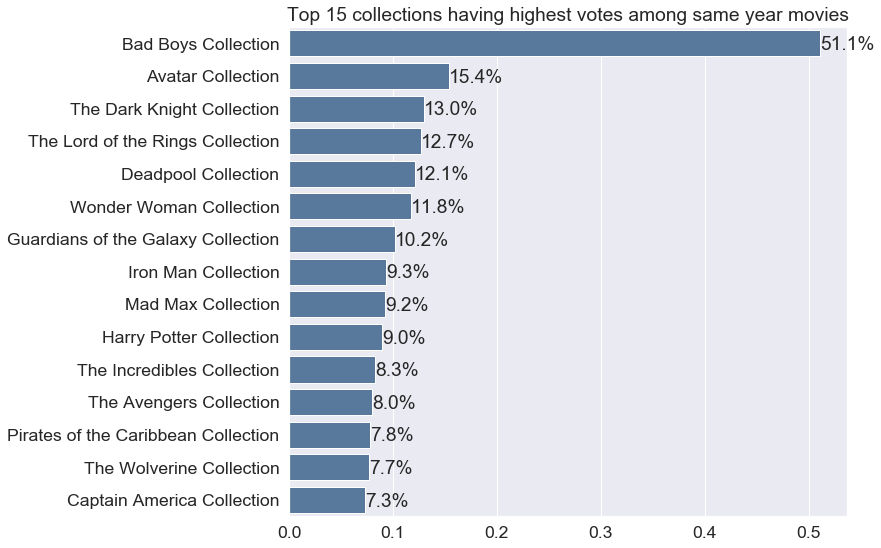

In [70]:
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(10,9))

sns.barplot(y='collection',x='mean',data=vote_rank,orient='h',palette=['#4E79A7'])
for i,v in enumerate(vote_rank['mean']):
    ax.text(v,i+.2,vote_rank['percent'][i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Top 15 collections having highest votes among same year movies')

### pivot on vote percenta of each collection

In [15]:
fran_pivot_adj_revenue = df_fran.pivot_table(index='collection', values='adj_revenue', aggfunc={'adj_revenue': ['mean', 'sum', 'count','std']}).reset_index()
revenue_rank=fran_pivot_adj_revenue.sort_values('mean',ascending=False).head(15).reset_index().drop(['index'],axis=1).iloc[:,[0,2]]

KeyError: 'collection'

## Format revenue into billion dollars.

In [80]:
def billion(i):
    return '$'+'{:.2f}'.format((i/1e9))+'B'

revenue_rank['adjusted_revenue']=revenue_rank['mean'].apply(billion)

## Top 15 for average of adjusted revenue in Billion

Text(0.5, 1.0, 'Top 15 for average of adjusted revenue in Billion')

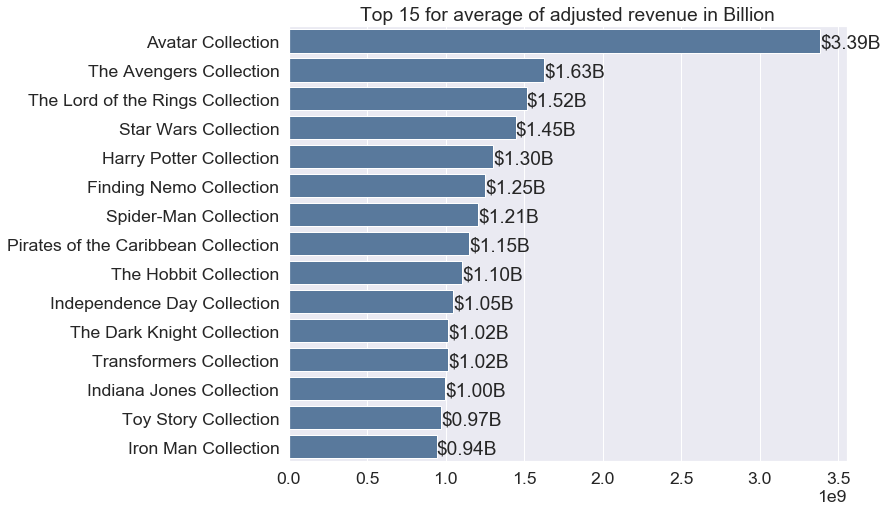

In [133]:
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(y='collection',x='mean',data=revenue_rank,orient='h',palette=['#4E79A7'])
#ax.set_yticklabels(revenue_rank['adjusted_revenue'], minor=False)
for i,v in enumerate(revenue_rank['mean']):
    ax.text(v+4,i+0.25,revenue_rank['adjusted_revenue'][i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Top 15 for average of adjusted revenue in Billion')

## Most stable revenue collections ( having more than 2 movies and average revenue > 10 million)

Text(0.5, 1.0, 'Top 15 for average of adjusted revenue in Billion')

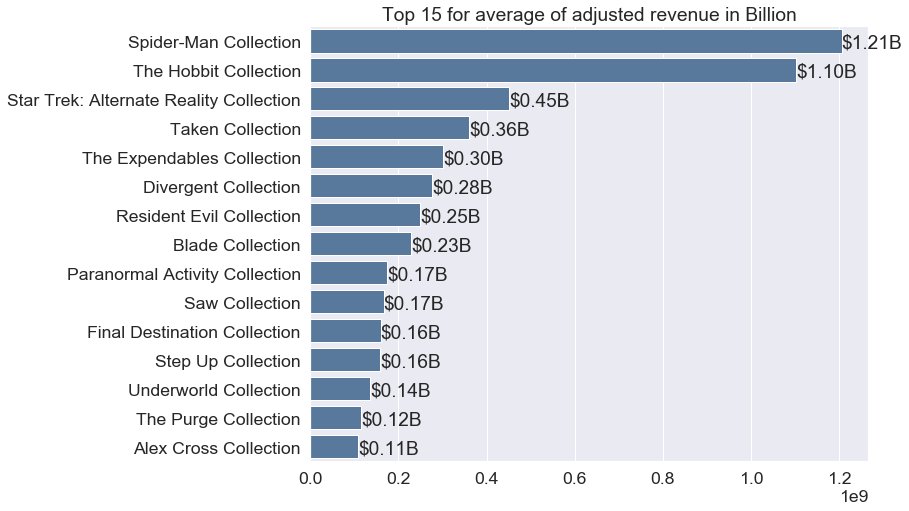

In [182]:
stable=fran_pivot_adj_revenue[(fran_pivot_adj_revenue['sum']>1e8)&(fran_pivot_adj_revenue['count']>2)].sort_values('std').head(50).sort_values('mean',ascending=False).head(15)


stable['adjusted_revenue']=stable['mean'].apply(billion)
stable=stable.reset_index()
stable=stable[['collection','mean','adjusted_revenue']]
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(10,8))

sns.barplot(y='collection',x='mean',data=stable,orient='h',palette=['#4E79A7'])
for i,v in enumerate(stable['mean']):
    ax.text(v+2,i+.25,stable['adjusted_revenue'][i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Top 15 highest revenue collecion in 100 most stable collection')


In [176]:
fran_pivot.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,mean,std,sum
398,Harry Potter Collection,8,1.299821e+09,1.806660e+08,1.039857e+10
833,Star Wars Collection,5,1.446228e+09,5.045716e+08,7.231140e+09
468,James Bond Collection,8,8.152455e+08,2.091642e+08,6.521964e+09
945,The Fast and the Furious Collection,8,7.301413e+08,4.997011e+08,5.841130e+09
692,Pirates of the Caribbean Collection,5,1.150427e+09,2.605925e+08,5.752134e+09
1088,Transformers Collection,5,1.015576e+09,2.660360e+08,5.077882e+09
988,The Lord of the Rings Collection,3,1.515102e+09,1.538453e+08,4.545307e+09
796,Shrek Collection,5,8.111941e+08,5.032155e+08,4.055970e+09
441,Ice Age Collection,5,8.063034e+08,2.777908e+08,4.031517e+09
246,Despicable Me Collection,6,6.668924e+08,5.557816e+08,4.001355e+09


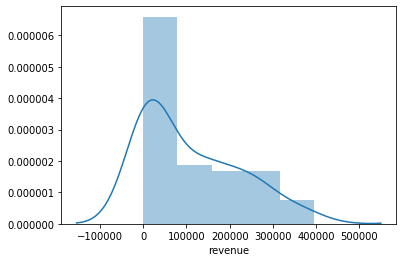

In [136]:
sns.distplot(df_fran[(df_fran['revenue']<500000)&(df_fran['revenue']>1)]['revenue'])